<a href="https://colab.research.google.com/github/WianStipp/TechXperience-Philips/blob/master/MainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/WianStipp/TechXperience-Philips.git

fatal: destination path 'TechXperience-Philips' already exists and is not an empty directory.


## Import Data and Scale

In [0]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [0]:
def resize_image(image):
  scale_percent = 4 # percent of original size
  width = 224
  height = 224
  dim = (width, height)
  image = cv2.resize(image, dsize =dim)

  return image

In [0]:
train_path = '/content/TechXperience-Philips/dataset/train'
training_names = os.listdir(train_path)
image_paths = []
image_classes = []
class_id = 0

def imglist(path):    
    return [os.path.join(path, f) for f in os.listdir(path)]

for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [0]:
val_path = '/content/TechXperience-Philips/dataset/val'  
val_names = os.listdir(val_path)

image_paths_val = []
image_classes_val = []
class_id_val = 0

for val_name in val_names:
    dir = os.path.join(val_path, val_name)
    class_path_val = imglist(dir)
    image_paths_val+=class_path_val
    image_classes_val+=[class_id_val]*len(class_path_val)
    class_id_val+=1


In [0]:
class_names_val = {np.unique(image_classes_val)[0]: val_names[0],
               np.unique(image_classes_val)[1]: val_names[1],
               np.unique(image_classes_val)[2]: val_names[2],
               np.unique(image_classes_val)[3]: val_names[3]}

In [0]:
for image_path in image_paths:
    im = cv2.imread(image_path)
    im = resize_image(im)
    status = cv2.imwrite('/content/TechXperience-Philips/dataset/train_scaled/' + image_path.split("/")[-2] + "/" + image_path.split("/")[-1], im)

In [0]:
for image_path in image_paths_val:
    im = cv2.imread(image_path)
    im = resize_image(im)
    status = cv2.imwrite('/content/TechXperience-Philips/dataset/val_scaled/' + image_path.split("/")[-2] + "/" + image_path.split("/")[-1], im)

## Import Scaled Data

In [0]:
train_path = '/content/TechXperience-Philips/dataset/train_scaled'
training_names = os.listdir(train_path)
image_paths = []
image_classes = []
class_id = 0
training_names.sort()

def imglist(path):    
    return [os.path.join(path, f) for f in os.listdir(path)]

for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    class_path = imglist(dir)
    class_path = [x for x in class_path if x[-1] != "T"] 
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [0]:
class_names_train = {np.unique(image_classes)[0]: training_names[0],
               np.unique(image_classes)[1]: training_names[1],
               np.unique(image_classes)[2]: training_names[2],
               np.unique(image_classes)[3]: training_names[3]}

In [0]:
val_path = '/content/TechXperience-Philips/dataset/val_scaled'  
val_names = os.listdir(val_path)
val_names.sort()
image_paths_val = []
image_classes_val = []
class_id_val = 0

for val_name in val_names:
    dir = os.path.join(val_path, val_name)
    class_path_val = imglist(dir)
    class_path_val = [x for x in class_path_val if x[-1] != "T"] 
    image_paths_val+=class_path_val
    image_classes_val+=[class_id_val]*len(class_path_val)
    class_id_val+=1

In [0]:
class_names_val = {np.unique(image_classes_val)[0]: val_names[0],
               np.unique(image_classes_val)[1]: val_names[1],
               np.unique(image_classes_val)[2]: val_names[2],
               np.unique(image_classes_val)[3]: val_names[3]}

In [0]:
assert class_names_val == class_names_train

In [0]:
from PIL import *

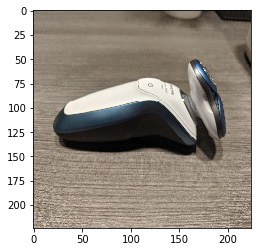

In [0]:
X_train = np.array([np.array(Image.open(fname)) for fname in image_paths if fname[-1] != "T"])
plt.imshow(X_train[6].astype(int))
#X_train_norm = X_train / 255
X_valid = np.array([np.array(Image.open(fname)) for fname in image_paths_val if fname[-1] != "T"])
#X_valid_norm = X_valid / 255
Y_train = image_classes
Y_valid = image_classes_val

In [0]:
print("Training Shape:", X_train.shape)
print("Validation Shape:", X_valid.shape)

Training Shape: (52, 224, 224, 3)
Validation Shape: (12, 224, 224, 3)


In [0]:
from keras.utils import to_categorical
y_train = to_categorical(Y_train)
y_valid = to_categorical(Y_valid)

## Build Model (Transfer Learning)

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input

In [0]:
# Load ResNet50 Trained on imagenet
resnet_model = ResNet50(weights="imagenet")

In [0]:
X_train_preprocessed = preprocess_input(X_train)
X_valid_preprocessed = preprocess_input(X_valid)

In [0]:
import tensorflow as tf

In [0]:
# Build a new model that is ResNet50 minus the very last layer
last_layer = resnet_model.get_layer("avg_pool")

resnet_layers = tf.keras.Model(inputs=resnet_model.inputs, outputs=last_layer.output)
resnet_layers.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
new_model=Sequential()
new_model.add(resnet_layers)
new_model.add(Dense(4, activation="sigmoid"))

new_model.layers[0].trainable=False

new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


## Training Time

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

In [0]:
# We can allow some of the resnet layers to change as we train.  
# Typically you would want to lower the learning rate in conjunction with this.

new_model.layers[0].trainable = True

# We let the last 3 blocks train
for layer in new_model.layers[0].layers[:-11]:
    layer.trainable = False
for layer in new_model.layers[0].layers[-11:]:
    layer.trainable = True
    
new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

new_model.fit(X_train_preprocessed, y_train, epochs=10, validation_data=(X_valid_preprocessed, y_valid), callbacks=[reduce_lr, mcp_save, earlyStopping], batch_size=32)

Train on 52 samples, validate on 12 samples


KeyboardInterrupt: ignored

## Testing and Validation

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(np.argmax(y_valid, axis=1), np.argmax(new_model.predict(x=X_valid_preprocessed),axis=1))

array([[3, 0, 0, 0],
       [0, 3, 0, 0],
       [0, 0, 3, 0],
       [0, 0, 0, 3]])

In [0]:
accuracy_score(np.argmax(y_valid, axis=1), np.argmax(new_model.predict(x=X_valid_preprocessed),axis=1))

1.0

#### Checking the model can make predictions on images taken from Google

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving series-5-feature-shaver-in-table.jpg to series-5-feature-shaver-in-table.jpg
User uploaded file "series-5-feature-shaver-in-table.jpg" with length 84823 bytes


In [0]:
TEST1 = np.array(Image.open(fn))

In [0]:
TEST1 = resize_image(TEST1)

In [0]:
TEST1_processed = preprocess_input(TEST1)

In [0]:
class_names_train

{0: 'shaver', 1: 'smart-baby-bottle', 2: 'toothbrush', 3: 'wake-up-light'}

In [0]:
np.argmax(new_model.predict(TEST1_processed.reshape(1,224,224,3)))

0

In [0]:
new_model.predict(TEST1_processed.reshape(1,224,224,3))

array([[1., 0., 0., 0.]], dtype=float32)

In [0]:
new_model.save("PhilipsModel.h5", include_optimizer=False)

In [0]:
model2 = tf.keras.models.load_model("PhilipsModel.h5")

ValueError: ignored